# Extract, Transform, Load (más o menos...)

El objetivo de este notebook es cargar las imágenes, preprocesarlas y exportarlas a kaggle para entrenar nuestros modelos.

In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

from sklearn.preprocessing import LabelEncoder
from skimage.io import imread, imsave
from skimage import exposure

import tensorflow as tf
import tensorflow_hub as hub

Vamos a recopilar imágenes de fuentes distintas. La primera (y más obvia) es la dada a todos en kaggle. La otra procede de un repositorio dispoible en github. Al ejecutar este notebook debería quedar un directorio con todas lás imágenes del mismo tamaño e igualmente preprocesadas.

<a href= 'https://www.kaggle.com/c/vision-artificial-upna2021-clasificacion-monedas/data'>vision-artificial-upna2021-clasificacion-monedas</a>

<a href= 'https://github.com/SuperDiodo/euro-coin-dataset'>euro-coin-dataset</a>

In [64]:
ORIGINAL_DATASET_PATH = '../data/train'
GITHUB_DATASET_PATH = '../data/euro-coin-dataset'

FINAL_DATASET_PATH = '../data/trainPreprocesado'

In [8]:
# Detector de objetos para segmentar las imágenes
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [50]:
def crear_directorio():
    """
    Crea el directorio para almacenar las imagenes preprocesadas
    """

    os.makedirs(FINAL_DATASET_PATH, exist_ok=True)

    for folder in os.listdir(ORIGINAL_DATASET_PATH):
        print(folder)
        new_subfolder = os.path.join(FINAL_DATASET_PATH, folder)
        os.makedirs(new_subfolder, exist_ok=True)
crear_directorio()

10c
50c
20c
5c
2c
1e
1c
2e


In [48]:
def limpiar_directorio():
    all_images = glob(os.path.join(FINAL_DATASET_PATH, '*', '*.jpg'))

    for img_path in all_images:
        os.remove(img_path)

# limpiar_directorio()

# Dataset original

Vamos a crear un dataframe básico con los "metadatos" de las imágenes.

In [30]:
original_img_dir = ORIGINAL_DATASET_PATH

all_training_images = glob(os.path.join(original_img_dir, '*', '*.jpg'))
original_df = pd.DataFrame(dict(path = all_training_images))

original_df['category'] = original_df['path'].map(lambda x: os.path.basename(os.path.dirname(x)))
original_df = original_df.query('category != "valid"')

cat_enc = LabelEncoder()
original_df['category_id'] = cat_enc.fit_transform(original_df['category'])

print(original_df.shape)

original_df.sample(5)

(1297, 3)


,path,category,category_id
27,../data/train/10c/train_39_34.jpg,10c,0
730,../data/train/5c/train_33_24.jpg,5c,7
1051,../data/train/1e/train_32_4.jpg,1e,2
176,../data/train/10c/train_9_17.jpg,10c,0
224,../data/train/10c/train_21_49.jpg,10c,0


In [31]:
def correccion_ruido(img, th1=250, th2=5):
    
    t_img = img.copy()
    
    gray = cv2.cvtColor(t_img, cv2.COLOR_RGB2GRAY)
    mask1 = gray > th1
    mask2 = gray < th2
    
    img_blur = cv2.medianBlur(t_img, 5)
    
    t_img[mask1] = img_blur[mask1]
    t_img[mask2] = img_blur[mask2]
    
    return t_img

In [32]:
def get_boxes(results_fast_rcnn):
    """
    Obtiene una lista con los píxeles que encierran a cada una de las monedas encontradas en la imágen 
    """
    monedas = results_fast_rcnn.copy()
    
    mask = (monedas['detection_class_labels'] == 132) & (monedas['detection_scores'] > 0.20)

    for key in monedas.keys():
        monedas[key] = monedas[key][mask]
    
    return monedas['detection_boxes']


In [33]:
def fastRCNNboxing(img):
    
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis]

    results = detector(converted_img)
    results = {key:value.numpy() for key,value in results.items()}

    boxes = get_boxes(results)
    
    return boxes

In [34]:
def preprocesamiento_imagen(path, ruido= True, amp_rang_din= True, equalizacion= True, apply_fastRCNN= True):

    img = imread(path)
    
    if np.all(img == 0) or np.all(img == 255):
        return None
    
    if ruido:
        img = correccion_ruido(img, 230, 20)
    
    if amp_rang_din:
        p2, p98 = np.percentile(img, (0,100))
        img = exposure.rescale_intensity(img, in_range=(p2,p98))

    if equalizacion:
        img = np.uint8(exposure.equalize_adapthist(img, clip_limit=0.003)*255)

    if apply_fastRCNN:
        imgs = []

        h, w = img.shape[0:2]

        boxes = fastRCNNboxing(img)
        if boxes is None:
            return None

        for box in boxes:
            up, left, down, right = box
            
            up = np.int16(up * w)
            left = np.int16(left * h)
            down = np.int16(down * w)
            right = np.int16(right * h)
            imgs.append((img[up:down, left:right]))

        return imgs
    
    img = cv2.resize(img, (224,224), fx=1, fy=1, interpolation= cv2.INTER_CUBIC)

    return img

In [52]:
# preprocesamiento a aplicar
eliminar_ruido = True
ampliacion_rango = True
equalizacion = True
apply_boxing = False

# crear_directorio()
# limpiar_directorio()

for path, category in tqdm(original_df[['path', 'category']].values):
    file_name = path[path.find('train_'):]

    if apply_boxing:
        lista_img = preprocesamiento_imagen(path, eliminar_ruido, ampliacion_rango, equalizacion, apply_boxing)
        
        if lista_img is not None and lista_img != []:
            img = lista_img[0]
            img = cv2.resize(img, (224,224), fx=1, fy=1, interpolation= cv2.INTER_CUBIC)
            imsave(f"{FINAL_DATASET_PATH}/{category}/{file_name}", img)
        else:
            print(f"img {file_name} is None or empty (category: {category})")
    
    else:
        img = preprocesamiento_imagen(path, eliminar_ruido, ampliacion_rango, equalizacion, False)
        
        if img is not None:
            imsave(f"{FINAL_DATASET_PATH}/{category}/{file_name}", img)

100%|██████████| 1297/1297 [06:31<00:00,  3.31it/s]


In [53]:
antes = glob(os.path.join(ORIGINAL_DATASET_PATH, '*', '*.jpg'))
despues = glob(os.path.join(FINAL_DATASET_PATH, '*', '*.jpg'))

print(f"Número de imágenes originales: {len(antes)}")
print(f"Número de imágenes originales despúes del preprocesamiento: {len(despues)}")

Número de imágenes originales: 1297
Número de imágenes originales despúes del preprocesamiento: 1291


# Dataset de github

Antes de preprocesar este dataset vamos a ver como funciona el segmentador que hemos importado

(-0.5, 3023.5, 3023.5, -0.5)

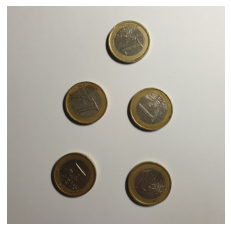

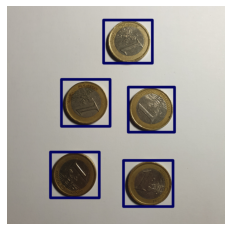

In [65]:
# leer imágenes
img = cv2.imread(GITHUB_DATASET_PATH+'/100/20210324_193013.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.figure()
# obtener lista de puntos
coins = fastRCNNboxing(img)

filas, cols = img.shape[0:2]

# mostrar los cuadrados
for up, left, down, right in coins:
    img = cv2.rectangle(img, (int(right*cols), int(up*filas)), (int(left*cols),int(down * filas)), (0x03,0x04,0x5e), 35)

plt.imshow(img)
plt.axis('off')

In [69]:
def get_category(pseudo_category):
    if pseudo_category == '1':
        return '1c'
    elif pseudo_category == '2':
        return '2c'
    elif pseudo_category == '5':
        return '5c'
    elif pseudo_category == '10':
        return '10c'
    elif pseudo_category == '20':
        return '20c'
    elif pseudo_category == '50':
        return '50c'
    elif pseudo_category == '100':
        return '1e'
    elif pseudo_category == '200':
        return '2e'

In [70]:
github_img_dir = GITHUB_DATASET_PATH

all_training_images = glob(os.path.join(github_img_dir, '*', '*.jpg'))
github_df = pd.DataFrame(dict(path = all_training_images))

# el dataset no contiene las categorías que nosotros manejamos
github_df['pseudo_category'] = github_df['path'].map(lambda x: os.path.basename(os.path.dirname(x)))

github_df['category'] = github_df['pseudo_category'].map(lambda x: get_category(x))
cat_enc = LabelEncoder()
github_df['category_id'] = cat_enc.fit_transform(github_df['category'])

print(github_df.shape)

# Aunque este dataset solo contiene 459 imágenes cada una muestra entre 4 y 7 monedas. 
# La idea es usar el detector entrenado sobre Open Image para segmentar las imágenes. Así escribiremos
# varias imágenes por cada una de estas que leamos.

github_df.sample(5)

(459, 4)


,path,pseudo_category,category,category_id
182,../data/euro-coin-dataset/10/20210324_154618.jpg,10,10c,0
450,../data/euro-coin-dataset/5/20210324_153917.jpg,5,5c,7
331,../data/euro-coin-dataset/2/20210324_153402.jpg,2,2c,4
415,../data/euro-coin-dataset/5/20210324_154143.jpg,5,5c,7
269,../data/euro-coin-dataset/200/20210327_181729.jpg,200,2e,5


In [71]:
# Distribución de las imágenes de github
github_df['category'].value_counts()

2c     74
10c    73
5c     71
1c     63
2e     47
50c    44
20c    44
1e     43
Name: category, dtype: int64

In [73]:
FINAL_DATASET_PATH

'../data/trainPreprocesado'

In [80]:
eliminar_ruido = True
ampliacion_rango = True
equalizacion = True
apply_boxing = True # No queda otra ya que hay varias monedas por imágen

for path, pseudo_cat, category in tqdm(github_df[['path', 'pseudo_category', 'category']].values):
    file_name = os.path.basename(path)
    lista_img = preprocesamiento_imagen(path, eliminar_ruido, ampliacion_rango, equalizacion, apply_boxing)
    lista_img = []

    if lista_img is not None and lista_img != []:
        for index, img in enumerate(lista_img):
            img = cv2.resize(img, (224,224), fx=1, fy=1, interpolation= cv2.INTER_CUBIC)
            imsave(f"{FINAL_DATASET_PATH}/{category}/train_{index}_{file_name}", img)
            if index >= 6: 
                break

100%|██████████| 459/459 [00:00<00:00, 249991.63it/s]


In [ ]:
actual = glob(os.path.join(FINAL_DATASET_PATH, '*', '*.jpg'))

print(f"Número de imágenes actual: {len(actual)}")

Número de imágenes actual: 2671


In [ ]:
final_img_dir = FINAL_DATASET_PATH

all_training_images = glob(os.path.join(final_img_dir, '*', '*.jpg'))
final_df = pd.DataFrame(dict(path = all_training_images))

final_df['file_path'] = final_df['path'].map(lambda x: x[x.find('/train_')+1:])

final_df['category'] = final_df['path'].map(lambda x: os.path.basename(os.path.dirname(x)))

cat_enc = LabelEncoder()
final_df['category_id'] = cat_enc.fit_transform(final_df['category'])

print(final_df.shape)

final_df[1:].sample(5)

(2671, 4)


,path,file_path,category,category_id
216,/Users/ito/miUpna/Informatica/3/3.1/Vision/3_U...,train_4_20210324_154851.jpg,10c,0
108,/Users/ito/miUpna/Informatica/3/3.1/Vision/3_U...,train_0_20210324_154941.jpg,10c,0
1462,/Users/ito/miUpna/Informatica/3/3.1/Vision/3_U...,train_3_20210324_153935.jpg,5c,7
378,/Users/ito/miUpna/Informatica/3/3.1/Vision/3_U...,train_29_12.jpg,10c,0
639,/Users/ito/miUpna/Informatica/3/3.1/Vision/3_U...,train_40_35.jpg,50c,6


In [82]:
original_img_dir = ORIGINAL_DATASET_PATH

all_training_images = glob(os.path.join(original_img_dir, '*', '*.jpg'))
original_df = pd.DataFrame(dict(path = all_training_images))

original_df['file_path'] = original_df['path'].map(lambda x: x[x.find('/train_')+1:])

original_df['category'] = original_df['path'].map(lambda x: os.path.basename(os.path.dirname(x)))

cat_enc = LabelEncoder()
original_df['category_id'] = cat_enc.fit_transform(original_df['category'])

print(original_df.shape)

original_df[1:].sample(5)

(1297, 4)


,path,file_path,category,category_id
973,../data/train/1e/train_26_7.jpg,train_26_7.jpg,1e,2
1156,../data/train/1e/train_2_3.jpg,train_2_3.jpg,1e,2
1182,../data/train/1c/train_21_44.jpg,train_21_44.jpg,1c,1
357,../data/train/50c/train_34_25.jpg,train_34_25.jpg,50c,6
202,../data/train/10c/train_13_12.jpg,train_13_12.jpg,10c,0


In [83]:
# distribución original de cada clase, está muy desvalanceado
r = original_df['category'].value_counts()
r / len(original_df)

5c     0.218967
10c    0.195837
1e     0.191210
20c    0.175019
50c    0.101002
1c     0.061681
2e     0.037008
2c     0.019275
Name: category, dtype: float64

In [ ]:
# nueva distribución, sigue desvalanceado pero mucho menos
r = final_df['category'].value_counts()
r / len(final_df)

5c     0.203295
10c    0.184575
1e     0.134781
20c    0.129914
50c    0.099588
1c     0.093972
2c     0.083489
2e     0.070386
Name: category, dtype: float64

In [ ]:
final_df[['file_path', 'category', 'category_id']].head()

,file_path,category,category_id
0,train_21_56.jpg,10c,0
1,train_5_20210324_154604.jpg,10c,0
2,train_0_20210324_154602.jpg,10c,0
3,train_1_20210324_154549.jpg,10c,0
4,train_0_20210328_160912.jpg,10c,0


In [ ]:
final_df[['file_path', 'category', 'category_id']].to_csv("train.csv", index=False)

In [ ]:
# !zip -r trainPreprocesado.zip img/trainPreprocesado

  adding: img/trainPreprocesado/ (stored 0%)
  adding: img/trainPreprocesado/10c/ (stored 0%)
  adding: img/trainPreprocesado/10c/train_21_56.jpg (deflated 1%)
  adding: img/trainPreprocesado/10c/train_5_20210324_154604.jpg (deflated 2%)
  adding: img/trainPreprocesado/10c/train_0_20210324_154602.jpg (deflated 1%)
  adding: img/trainPreprocesado/10c/train_1_20210324_154549.jpg (deflated 1%)
  adding: img/trainPreprocesado/10c/train_0_20210328_160912.jpg (deflated 1%)
  adding: img/trainPreprocesado/10c/train_8_4.jpg (deflated 1%)
  adding: img/trainPreprocesado/10c/train_11_22.jpg (deflated 1%)
  adding: img/trainPreprocesado/10c/train_30_13.jpg (deflated 2%)
  adding: img/trainPreprocesado/10c/train_23_47.jpg (deflated 2%)
  adding: img/trainPreprocesado/10c/train_37_26.jpg (deflated 1%)
  adding: img/trainPreprocesado/10c/train_30_12.jpg (deflated 2%)
  adding: img/trainPreprocesado/10c/train_4_20210324_154604.jpg (deflated 1%)
  adding: img/trainPreprocesado/10c/train_39_22.jpg (def

# Test

In [86]:
TEST_DATASET_PATH = '../data/public_test'
TEST_DESTINATION_PATH = '../data/testPreprocesado'

test_img_dir = TEST_DATASET_PATH

all_test_images = glob(os.path.join(test_img_dir, '*.jpg'))

test_df = pd.DataFrame(dict(path = all_test_images))

test_df['Id'] = test_df['path'].map(lambda x: x[x.find('test')+5:])

test_df.sample(5)

,path,Id
451,../data/public_test/IMG_452421c9c7e3-5360-11ec...,IMG_452421c9c7e3-5360-11ec-a988-ec2e98cc05dc.jpg
125,../data/public_test/IMG_21972200978f-5360-11ec...,IMG_21972200978f-5360-11ec-8d75-ec2e98cc05dc.jpg
598,../data/public_test/IMG_8921589eb4-5360-11ec-a...,IMG_8921589eb4-5360-11ec-a865-ec2e98cc05dc.jpg
870,../data/public_test/IMG_2957224993ec-5360-11ec...,IMG_2957224993ec-5360-11ec-885e-ec2e98cc05dc.jpg
173,../data/public_test/IMG_387321767a6b-5360-11ec...,IMG_387321767a6b-5360-11ec-b6c8-ec2e98cc05dc.jpg


In [89]:
def crear_directorio_test():
    """
    Crea el directorio para almacenar las imagenes preprocesadas
    """

    os.makedirs(TEST_DESTINATION_PATH, exist_ok=True)

    for folder in os.listdir(ORIGINAL_DATASET_PATH):
        new_subfolder = os.path.join(TEST_DESTINATION_PATH, folder)
        os.makedirs(new_subfolder, exist_ok=True)

crear_directorio_test()

In [87]:
def limpiar_directorio_test():
    all_images = glob(os.path.join(TEST_DESTINATION_PATH, '*.jpg'))

    for img_path in all_images:
        os.remove(img_path)
        
#limpiar_directorio_test()

In [ ]:
eliminar_ruido = True
ampliacion_rango = True
equalizacion = True
apply_boxing = False

for path, file_name in tqdm(test_df[['path', 'Id']].values):

    img = preprocesamiento_imagen(path, eliminar_ruido, ampliacion_rango, equalizacion, False)
    
    if img is not None:
        img = cv2.resize(img, (224,224), fx=1, fy=1, interpolation= cv2.INTER_CUBIC)
        imsave(f"{TEST_DESTINATION_PATH}/{file_name}", img)
    else:
        print(f'Problem on {file_name}')

100%|██████████| 964/964 [03:22<00:00,  4.75it/s]


In [91]:
test_df['Id'].to_csv("../data/test.csv", index=False)

In [92]:
!zip -r ../testPrepro.zip ../data/testPreprocesado

  adding: ../data/testPreprocesado/ (stored 0%)
  adding: ../data/testPreprocesado/10c/ (stored 0%)
  adding: ../data/testPreprocesado/50c/ (stored 0%)
  adding: ../data/testPreprocesado/20c/ (stored 0%)
  adding: ../data/testPreprocesado/5c/ (stored 0%)
  adding: ../data/testPreprocesado/2c/ (stored 0%)
  adding: ../data/testPreprocesado/1e/ (stored 0%)
  adding: ../data/testPreprocesado/1c/ (stored 0%)
  adding: ../data/testPreprocesado/2e/ (stored 0%)
